# Ensembling With Multiple Objectives
Last Updated by Developer 23/8/2023

This notebook looks at optimizing an ensemble model with the explicit intention to make them as different as possible.

Ideas tested so far center around **Negative Correlation Learning** ([see here](https://arxiv.org/pdf/2011.02952.pdf)). It is quite intuitive: when we train the ensemble we add a penalty for model similarity. This is attempted in several ways using different loss functions: 
- based on correlation in prediction errors
    - this is a minimization problem, so we add it to the loss function with positive weight 
- based on difference between predictions 
    - this is a maximization problem, so we add it to the loss function with negative weight 
- based on difference between predictions from average prediction (which is also the ensemble's predictions)
    - this is a maximization problem, so we add it to the loss function with negative weight 

Because we are using MAE, some custom loss metrics are modified from squares to absolute values. This is to ensure consisntency in scale with our loss function so that MAE does not get overwhelmed (for instance, if we have a supplementary penalty that is a square, if it blows up the model will start to care more about it than MAE and differential weighting of losses does nothing to change this because one is linear and the other exponential)


Some other literature, of limited relevance/usefulness: 
https://proceedings.mlr.press/v151/ortega22a/ortega22a.pdf
https://arxiv.org/abs/1906.07380
https://arxiv.org/abs/1901.08846

## Load packages, data

In [22]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import os

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs
from sklearn import preprocessing

from ficc.utils.auxiliary_functions import sqltodf
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TF Version: 2.7.0


In [41]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-01-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1 #ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.1 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history_shortened'

In [3]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [4]:
%time processed_data = load_data_from_pickle('processed_data_2023-07-24-14:53.pkl', 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 14.7 s, sys: 6.48 s, total: 21.2 s
Wall time: 21.2 s


In [5]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [6]:
processed_data.reset_index(drop=True, inplace=True)
processed_data.sort_values('trade_datetime', inplace=True)

In [7]:
def process_data(data): 
    # data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [8]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [9]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 1min 56s, sys: 20 s, total: 2min 16s
Wall time: 4min 15s


In [10]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 1.68 s, sys: 148 ms, total: 1.82 s
Wall time: 1.85 s


In [11]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 37.3 s, sys: 18.4 s, total: 55.7 s
Wall time: 1min 6s


In [12]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [13]:
%%time 
processed_data = process_data(processed_data)

CPU times: user 54.6 s, sys: 22.5 s, total: 1min 17s
Wall time: 1min 30s


In [14]:
processed_data['moodys_rating'] = processed_data.moodys_long.fillna('NR')
processed_data['ratings_concat'] = processed_data['rating'] + processed_data['moodys_rating']

In [15]:
def modify_features(cols, how, where=None):
    #function to conveniently add or subtract features from the global feature lists 
    
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError(f"'how' argument must be one off the following: {['add','remove']}")
        
    if where and where not in ['categorical','binary', 'numeric']:
        raise ValueError(f"'where' argument must be one off the following: {['categorical','binary', 'numeric']}")
    
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

In [16]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

#add for the encoders, then remove later if needed 
modify_features(['rating','moodys_rating', 'ratings_concat'], how = 'add', where='categorical')   
    
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
# with open('encoders.pkl','wb') as file:
#     pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
moodys_rating
ratings_concat


In [17]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 3.29 s, sys: 47.9 ms, total: 3.34 s
Wall time: 3.34 s


In [18]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [19]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [20]:
len(train_dataframe), len(test_dataframe)

(3360391, 720563)

In [185]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:

        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)

    
    ### CONCATENATE EMBEDDINGS
    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)


    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def generate_bottleneck_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:

        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset


#!pip install gpustat
from tensorflow.keras.callbacks import Callback
import regex as r
import gpustat

class LossCallback(Callback):
    def on_epoch_begin(self, batch, logs={}):
        super().on_epoch_begin(batch)
        self.gpu_usage = []
        
    def on_train_batch_end(self, batch, logs={}):  
        if batch % 25 == 0:
            s = str(gpustat.new_query()[0])
            gpu_usage = int(r.findall('[0-9]+ %', s)[0].split('%')[0])
            self.gpu_usage.append(gpu_usage)
        
    def on_epoch_end(self, epoch, logs=None):
        s = str(gpustat.new_query()[0])
        gpu_mem = r.findall('[0-9]+ / [0-9]+', s)[0].replace(' ', '')
        
        if logs is None:
            logs = {}
            
        train_loss = []
        val_loss = []
        
        
        train_loss_cols = [x for x in logs.keys() if 'val' not in x][1:]
        val_loss_cols = [x for x in logs.keys() if 'val' in x][1:]
        
        for loss in train_loss_cols:
            if loss == 'loss':
                continue
            else: 
                train_loss.append(logs.get(loss, None))
                
        for loss in val_loss_cols:
            if loss == 'val_loss':
                continue
            else: 
                val_loss.append(logs.get(loss, None))
        
        if train_loss and val_loss:
            # print(f'Epoch {epoch + 1}')
            df = pd.DataFrame([train_loss, val_loss], 
                              index = ['Train loss', 'Val loss'],
                              # columns = [f'Ensemble_model_{i+1}' for i in range(ENSEMBLE_SIZE)],
                             columns = train_loss_cols)
            
            df['GPU MEMORY'] = gpu_mem
            df['MAX GPU USAGE'] = str(max(self.gpu_usage))+'%' if self.gpu_usage else None
            display(df)
            print()
            
loss_callback = LossCallback()

fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False),
    loss_callback
]

In [42]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []
modify_features(['moodys_rating', 'ratings_concat'], how = 'remove')   

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe,                                                                                                         
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, 
                                                                                                         yield_history_cols)

TRAINING DATA: N = 3024352, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 336039, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 720563, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-30 00:00:00


In [43]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

14
(3024352, 5, 6)
(3024352, 1, 3)
(3024352, 48)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)


In [150]:
shuffle = True
shuffle_buffer = 0.75

TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
yield_history_cols = params.get('yield_history_cols')
yield_history_lengths = params.get('yield_history_lengths')
num_yield_history = params.get('num_yield_history')

yield_history_normalizers = normalizers.get('yield_history_normalizers')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')

tf.keras.utils.set_random_seed(10)

timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')

with tf.device('/cpu:0'):
    train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
    val_ds = create_tf_data(x_val, y_val, shuffle = False)
    val_ds = val_ds.batch(5000).prefetch(2).cache()

## Train Models

To implement negative correlation learning for an ensemble network, we generate a model with multiple outputs. The output has 2 parts: 
- For an ensemble of size K, our model outputs K seperate scalars, each corresponding to the output of each ensemble in the model. 
- Separately, a vector of length K, which is a concatenation of all the individual outputs. 
- The model hence has an output of size 2*K, and more specifically, it has the shape [1, 1,... ,1, k]

To train an ensemble together, we need to pass multiple loss functions, each corresponding to each output. For the individual model outputs, the loss function is the MAE. For the concatenated model output, the loss function is the custom loss function representing a penalty on model similarity.

In [757]:
tf.keras.backend.clear_session()
gc.collect()

ENSEMBLE_SIZE = 4
models = []
for i in range(ENSEMBLE_SIZE):
    if i < ENSEMBLE_SIZE/2:
        models.append(generate_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                           yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer))
    else:
        models.append(generate_bottleneck_model(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                           yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer))

In [758]:
input_layer = models[0].input
output_list = [model(input_layer) for model in models]
output_concat = layers.Concatenate()(output_list)
ensemble_base = keras.Model(inputs = input_layer, outputs = output_list + [output_concat])

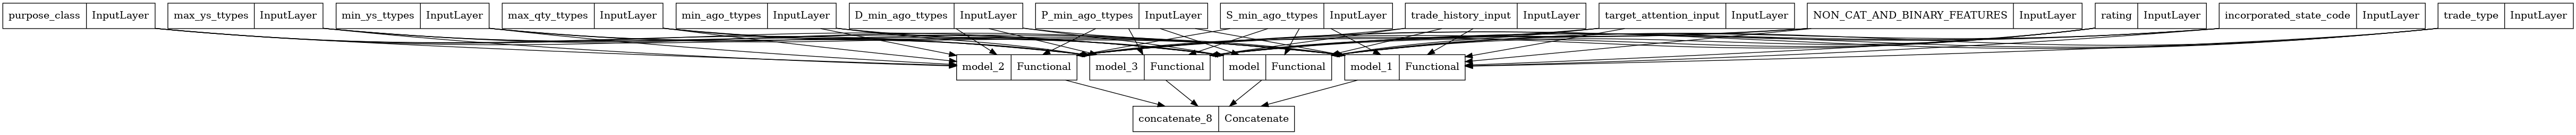

In [759]:
keras.utils.plot_model(ensemble_base)

Ideas tested so far center around **Negative Correlation Learning** ([see here](https://arxiv.org/pdf/2011.02952.pdf)). It is quite intuitive: when we train the ensemble we add a penalty for model similarity. This is attempted in several ways using different loss functions: 
- based on correlation in prediction errors **[min_corr_loss]**
    - this is a minimization problem, so we add it to the loss function with positive weight 
- based on difference between predictions **[max_diff_loss]**
    - this is a maximization problem, so we add it to the loss function with negative weight 
- based on difference between predictions from average prediction (which is also the ensemble's predictions) **[max_diff_mean_loss]**
    - this is a maximization problem, so we add it to the loss function with negative weight 
    
**For ensemble of size >2, we should probably be taking the average value of each loss. For example, for max_diff_mean_loss, we should take the average difference between each model prediction and the average prediction. This is only properly implemented for min_corr_loss.**
    
    
    
In rough testing, it it seems like min_corr_loss converges better than the other functions, and even then it takes some effort. Training was performed in three phases, each time with the learning rate being halved, starting at the original value of 0.0001. The total epochs was more than 150, which is not tenable in production, at least not now. 

In [1031]:
def max_diff_mean_loss(y_true, y_pred):
    #more negative means more diversity 
    y1 = y_pred[:, 0] 
    y2 = y_pred[:, 1] 
    y_avg = y1 + y2 / 2 
    
    return -tf.reduce_mean(tf.pow(y1-y_avg, 2) + tf.pow(y2-y_avg,2))

def max_diff_loss(y_true, y_pred):
    #more negative means more diversity
    return -tf.math.log(tf.reduce_sum(tf.abs(y_pred[:, 0] - y_pred[:, 1])))

def min_corr_loss(y_true, y_pred):
    #smaller means more diversity

    y1 = y_pred[:, 0] - y_true
    y2 = y_pred[:, 1] - y_true
    mean1 = tf.reduce_mean(y1)
    mean2 = tf.reduce_mean(y2)
    std1 = tf.math.reduce_std(y1)
    std2 = tf.math.reduce_std(y2)
    corr = tf.reduce_mean((y1 - mean1) * (y2 - mean2)) / (std1 * std2)

    return corr

def min_corr_loss(y_true, y_pred):
    #correlation is calculated as Cov(X,Y)/Sd(X)Sd(Y)
    #in matrix form, that is S^-1 @ C @ S^-1 where S is a diagonal matrix of standard deviations and C is the covariance matrix  
    
    matrix = y_pred - y_true 
    
    mean = tf.reduce_mean(matrix, axis=0)

    centered_matrix = matrix - mean

    covariance_matrix = tf.matmul(centered_matrix, centered_matrix, transpose_a=True) / tf.cast(tf.shape(matrix)[0]-1, tf.float32)

    stddev = tf.math.sqrt(tf.reduce_sum(tf.square(centered_matrix), axis=0) / tf.cast(tf.shape(matrix)[0]-1, tf.float32))    
    
    stddev = tf.linalg.inv(tf.linalg.diag(stddev))

    correlation_matrix = stddev @ covariance_matrix @ stddev

    return ((tf.reduce_sum(correlation_matrix) - tf.linalg.trace(correlation_matrix)) \
            / tf.constant(correlation_matrix.shape[0]**2 - correlation_matrix.shape[0], tf.float32))

Testing the loss function by comparing to numpy's calculations:

In [1027]:
test_arr = np.array([[0.5, 1, 1.5], [0.5, 1, 1.5], [0.5,1, 1.5]])
test_label = np.array([[0.5],[1],[1.5]])

In [1030]:
np.corrcoef((test_arr - test_label))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [1033]:
min_corr_loss(
    tf.constant(test_arr, tf.float32),
    tf.constant(test_label, tf.float32)
             )

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

Training the model:

In [ ]:
histories = [] 
mae = keras.losses.MeanAbsoluteError()
for LR in [0.0001, 0.00005, 0.00025]:
    ensemble_base.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                 loss = [mae for _ in range(ENSEMBLE_SIZE)] + [min_corr_loss],
                     loss_weights= [1 for _ in range(ENSEMBLE_SIZE)] + [(ENSEMBLE_SIZE/2)])
    
    hist = ensemble_base.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=75,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)
    histories.append(hist)

Epoch 1/75


2023-08-27 21:58:48.562357: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-27 21:58:48.562548: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3025/3025 [==============================] - ETA: 0s - loss: 121.1100 - model_loss: 43.3137 - model_1_loss: 43.1183 - model_2_loss: 15.4760 - model_3_loss: 17.8285 - concatenate_8_loss: 0.3434

2023-08-27 22:03:36.369985: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-27 22:03:36.370131: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,43.314,43.118,15.476,17.828,0.343,10716/15360,91%
Val loss,31.416,31.189,10.636,10.689,0.353,10716/15360,91%



3025/3025 [==============================] - 318s 96ms/step - loss: 121.1100 - model_loss: 43.3137 - model_1_loss: 43.1183 - model_2_loss: 15.4760 - model_3_loss: 17.8285 - concatenate_8_loss: 0.3434 - val_loss: 85.3432 - val_model_loss: 31.4165 - val_model_1_loss: 31.1887 - val_model_2_loss: 10.6360 - val_model_3_loss: 10.6890 - val_concatenate_8_loss: 0.3533
Epoch 2/75
3025/3025 [==============================] - ETA: 0s - loss: 59.7743 - model_loss: 18.6558 - model_1_loss: 18.5029 - model_2_loss: 10.5241 - model_3_loss: 10.5520 - concatenate_8_loss: 0.3849

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,18.656,18.503,10.524,10.552,0.385,10716/15360,90%
Val loss,10.324,10.348,10.070,10.074,0.465,10716/15360,90%



3025/3025 [==============================] - 284s 94ms/step - loss: 59.7743 - model_loss: 18.6558 - model_1_loss: 18.5029 - model_2_loss: 10.5241 - model_3_loss: 10.5520 - concatenate_8_loss: 0.3849 - val_loss: 42.6758 - val_model_loss: 10.3238 - val_model_1_loss: 10.3478 - val_model_2_loss: 10.0700 - val_model_3_loss: 10.0744 - val_concatenate_8_loss: 0.4650
Epoch 3/75
3025/3025 [==============================] - ETA: 0s - loss: 44.1440 - model_loss: 11.0196 - model_1_loss: 10.9942 - model_2_loss: 10.1628 - model_3_loss: 10.1552 - concatenate_8_loss: 0.4531

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,11.020,10.994,10.163,10.155,0.453,10716/15360,91%
Val loss,9.918,9.861,9.818,9.777,0.466,10716/15360,91%



3025/3025 [==============================] - 272s 90ms/step - loss: 44.1440 - model_loss: 11.0196 - model_1_loss: 10.9942 - model_2_loss: 10.1628 - model_3_loss: 10.1552 - concatenate_8_loss: 0.4531 - val_loss: 41.2352 - val_model_loss: 9.9180 - val_model_1_loss: 9.8607 - val_model_2_loss: 9.8178 - val_model_3_loss: 9.7766 - val_concatenate_8_loss: 0.4656
Epoch 4/75
3025/3025 [==============================] - ETA: 0s - loss: 43.0863 - model_loss: 10.6964 - model_1_loss: 10.6858 - model_2_loss: 9.9485 - model_3_loss: 9.9400 - concatenate_8_loss: 0.4539

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.696,10.686,9.948,9.940,0.454,10716/15360,91%
Val loss,9.705,9.693,9.655,9.614,0.473,10716/15360,91%



3025/3025 [==============================] - 285s 94ms/step - loss: 43.0863 - model_loss: 10.6964 - model_1_loss: 10.6858 - model_2_loss: 9.9485 - model_3_loss: 9.9400 - concatenate_8_loss: 0.4539 - val_loss: 40.5592 - val_model_loss: 9.7052 - val_model_1_loss: 9.6934 - val_model_2_loss: 9.6554 - val_model_3_loss: 9.6138 - val_concatenate_8_loss: 0.4728
Epoch 5/75
3025/3025 [==============================] - ETA: 0s - loss: 42.4639 - model_loss: 10.5367 - model_1_loss: 10.5162 - model_2_loss: 9.8019 - model_3_loss: 9.7932 - concatenate_8_loss: 0.4540

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.537,10.516,9.802,9.793,0.454,10716/15360,90%
Val loss,9.523,9.519,9.554,9.502,0.478,10716/15360,90%



3025/3025 [==============================] - 285s 94ms/step - loss: 42.4639 - model_loss: 10.5367 - model_1_loss: 10.5162 - model_2_loss: 9.8019 - model_3_loss: 9.7932 - concatenate_8_loss: 0.4540 - val_loss: 40.0097 - val_model_loss: 9.5230 - val_model_1_loss: 9.5192 - val_model_2_loss: 9.5535 - val_model_3_loss: 9.5023 - val_concatenate_8_loss: 0.4779
Epoch 6/75
3025/3025 [==============================] - ETA: 0s - loss: 42.0020 - model_loss: 10.4164 - model_1_loss: 10.3941 - model_2_loss: 9.6877 - model_3_loss: 9.6889 - concatenate_8_loss: 0.4537

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.416,10.394,9.688,9.689,0.454,10716/15360,90%
Val loss,9.457,9.465,9.417,9.422,0.477,10716/15360,90%



3025/3025 [==============================] - 270s 89ms/step - loss: 42.0020 - model_loss: 10.4164 - model_1_loss: 10.3941 - model_2_loss: 9.6877 - model_3_loss: 9.6889 - concatenate_8_loss: 0.4537 - val_loss: 39.6690 - val_model_loss: 9.4571 - val_model_1_loss: 9.4654 - val_model_2_loss: 9.4168 - val_model_3_loss: 9.4222 - val_concatenate_8_loss: 0.4769
Epoch 7/75
3025/3025 [==============================] - ETA: 0s - loss: 41.6421 - model_loss: 10.3198 - model_1_loss: 10.2981 - model_2_loss: 9.6045 - model_3_loss: 9.6050 - concatenate_8_loss: 0.4537

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.320,10.298,9.605,9.605,0.454,10716/15360,90%
Val loss,9.349,9.319,9.372,9.357,0.478,10716/15360,90%



3025/3025 [==============================] - 285s 94ms/step - loss: 41.6421 - model_loss: 10.3198 - model_1_loss: 10.2981 - model_2_loss: 9.6045 - model_3_loss: 9.6050 - concatenate_8_loss: 0.4537 - val_loss: 39.3085 - val_model_loss: 9.3489 - val_model_1_loss: 9.3187 - val_model_2_loss: 9.3717 - val_model_3_loss: 9.3573 - val_concatenate_8_loss: 0.4780
Epoch 8/75
3025/3025 [==============================] - ETA: 0s - loss: 41.3358 - model_loss: 10.2351 - model_1_loss: 10.2159 - model_2_loss: 9.5340 - model_3_loss: 9.5382 - concatenate_8_loss: 0.4531

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.235,10.216,9.534,9.538,0.453,10716/15360,90%
Val loss,9.279,9.266,9.309,9.298,0.481,10716/15360,90%



3025/3025 [==============================] - 274s 91ms/step - loss: 41.3358 - model_loss: 10.2351 - model_1_loss: 10.2159 - model_2_loss: 9.5340 - model_3_loss: 9.5382 - concatenate_8_loss: 0.4531 - val_loss: 39.0754 - val_model_loss: 9.2791 - val_model_1_loss: 9.2662 - val_model_2_loss: 9.3090 - val_model_3_loss: 9.2981 - val_concatenate_8_loss: 0.4808
Epoch 9/75
3025/3025 [==============================] - ETA: 0s - loss: 41.0765 - model_loss: 10.1636 - model_1_loss: 10.1465 - model_2_loss: 9.4788 - model_3_loss: 9.4772 - concatenate_8_loss: 0.4526

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.164,10.146,9.479,9.477,0.453,10716/15360,90%
Val loss,9.230,9.236,9.300,9.249,0.482,10716/15360,90%



3025/3025 [==============================] - 261s 86ms/step - loss: 41.0765 - model_loss: 10.1636 - model_1_loss: 10.1465 - model_2_loss: 9.4788 - model_3_loss: 9.4772 - concatenate_8_loss: 0.4526 - val_loss: 38.9412 - val_model_loss: 9.2298 - val_model_1_loss: 9.2362 - val_model_2_loss: 9.2998 - val_model_3_loss: 9.2488 - val_concatenate_8_loss: 0.4817
Epoch 10/75
3025/3025 [==============================] - ETA: 0s - loss: 40.8534 - model_loss: 10.1052 - model_1_loss: 10.0842 - model_2_loss: 9.4283 - model_3_loss: 9.4267 - concatenate_8_loss: 0.4522

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.105,10.084,9.428,9.427,0.452,10716/15360,91%
Val loss,9.183,9.155,9.232,9.221,0.481,10716/15360,91%



3025/3025 [==============================] - 283s 94ms/step - loss: 40.8534 - model_loss: 10.1052 - model_1_loss: 10.0842 - model_2_loss: 9.4283 - model_3_loss: 9.4267 - concatenate_8_loss: 0.4522 - val_loss: 38.7134 - val_model_loss: 9.1831 - val_model_1_loss: 9.1551 - val_model_2_loss: 9.2316 - val_model_3_loss: 9.2211 - val_concatenate_8_loss: 0.4806
Epoch 11/75
3025/3025 [==============================] - ETA: 0s - loss: 40.6545 - model_loss: 10.0470 - model_1_loss: 10.0297 - model_2_loss: 9.3876 - model_3_loss: 9.3831 - concatenate_8_loss: 0.4518

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,10.047,10.030,9.388,9.383,0.452,10716/15360,90%
Val loss,9.184,9.143,9.220,9.199,0.480,10716/15360,90%



3025/3025 [==============================] - 271s 89ms/step - loss: 40.6545 - model_loss: 10.0470 - model_1_loss: 10.0297 - model_2_loss: 9.3876 - model_3_loss: 9.3831 - concatenate_8_loss: 0.4518 - val_loss: 38.6673 - val_model_loss: 9.1838 - val_model_1_loss: 9.1434 - val_model_2_loss: 9.2200 - val_model_3_loss: 9.1987 - val_concatenate_8_loss: 0.4804
Epoch 12/75
3025/3025 [==============================] - ETA: 0s - loss: 40.4787 - model_loss: 9.9929 - model_1_loss: 9.9808 - model_2_loss: 9.3533 - model_3_loss: 9.3462 - concatenate_8_loss: 0.4514

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.993,9.981,9.353,9.346,0.451,10716/15360,91%
Val loss,9.090,9.110,9.212,9.130,0.480,10716/15360,91%



3025/3025 [==============================] - 284s 94ms/step - loss: 40.4787 - model_loss: 9.9929 - model_1_loss: 9.9808 - model_2_loss: 9.3533 - model_3_loss: 9.3462 - concatenate_8_loss: 0.4514 - val_loss: 38.4629 - val_model_loss: 9.0905 - val_model_1_loss: 9.1100 - val_model_2_loss: 9.2124 - val_model_3_loss: 9.1296 - val_concatenate_8_loss: 0.4801
Epoch 13/75
3025/3025 [==============================] - ETA: 0s - loss: 40.3171 - model_loss: 9.9519 - model_1_loss: 9.9385 - model_2_loss: 9.3163 - model_3_loss: 9.3070 - concatenate_8_loss: 0.4509

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.952,9.938,9.316,9.307,0.451,10716/15360,92%
Val loss,9.079,9.059,9.169,9.093,0.480,10716/15360,92%



3025/3025 [==============================] - 279s 92ms/step - loss: 40.3171 - model_loss: 9.9519 - model_1_loss: 9.9385 - model_2_loss: 9.3163 - model_3_loss: 9.3070 - concatenate_8_loss: 0.4509 - val_loss: 38.3183 - val_model_loss: 9.0788 - val_model_1_loss: 9.0588 - val_model_2_loss: 9.1691 - val_model_3_loss: 9.0930 - val_concatenate_8_loss: 0.4796
Epoch 14/75
2364/3025 [======================>.......] - ETA: 56s - loss: 40.1705 - model_loss: 9.9092 - model_1_loss: 9.8987 - model_2_loss: 9.2859 - model_3_loss: 9.2761 - concatenate_8_loss: 0.4502

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 39.8099 - model_loss: 9.8088 - model_1_loss: 9.7954 - model_2_loss: 9.2118 - model_3_loss: 9.1976 - concatenate_8_loss: 0.4491

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.809,9.795,9.212,9.198,0.449,10716/15360,92%
Val loss,8.983,8.955,9.102,9.045,0.477,10716/15360,92%



3025/3025 [==============================] - 282s 93ms/step - loss: 39.8099 - model_loss: 9.8088 - model_1_loss: 9.7954 - model_2_loss: 9.2118 - model_3_loss: 9.1976 - concatenate_8_loss: 0.4491 - val_loss: 37.9934 - val_model_loss: 8.9835 - val_model_1_loss: 8.9552 - val_model_2_loss: 9.1017 - val_model_3_loss: 9.0454 - val_concatenate_8_loss: 0.4769
Epoch 18/75
 993/3025 [========>.....................] - ETA: 3:17 - loss: 39.7421 - model_loss: 9.8108 - model_1_loss: 9.7969 - model_2_loss: 9.1797 - model_3_loss: 9.1645 - concatenate_8_loss: 0.4476

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 39.5296 - model_loss: 9.7294 - model_1_loss: 9.7205 - model_2_loss: 9.1527 - model_3_loss: 9.1365 - concatenate_8_loss: 0.4476

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.729,9.720,9.153,9.136,0.448,10716/15360,92%
Val loss,8.921,8.923,9.007,8.983,0.476,10716/15360,92%



3025/3025 [==============================] - 275s 91ms/step - loss: 39.5293 - model_loss: 9.7293 - model_1_loss: 9.7205 - model_2_loss: 9.1526 - model_3_loss: 9.1364 - concatenate_8_loss: 0.4476 - val_loss: 37.7365 - val_model_loss: 8.9210 - val_model_1_loss: 8.9232 - val_model_2_loss: 9.0067 - val_model_3_loss: 8.9835 - val_concatenate_8_loss: 0.4755
Epoch 21/75
2697/3025 [=========================>....] - ETA: 28s - loss: 39.4358 - model_loss: 9.7010 - model_1_loss: 9.6933 - model_2_loss: 9.1349 - model_3_loss: 9.1176 - concatenate_8_loss: 0.4473

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 39.3668 - model_loss: 9.6857 - model_1_loss: 9.6764 - model_2_loss: 9.1167 - model_3_loss: 9.1009 - concatenate_8_loss: 0.4468

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.686,9.676,9.117,9.101,0.447,10716/15360,92%
Val loss,8.922,8.890,8.995,8.956,0.473,10716/15360,92%



3025/3025 [==============================] - 280s 92ms/step - loss: 39.3668 - model_loss: 9.6857 - model_1_loss: 9.6764 - model_2_loss: 9.1167 - model_3_loss: 9.1009 - concatenate_8_loss: 0.4468 - val_loss: 37.6548 - val_model_loss: 8.9217 - val_model_1_loss: 8.8900 - val_model_2_loss: 8.9951 - val_model_3_loss: 8.9559 - val_concatenate_8_loss: 0.4731
Epoch 23/75
2204/3025 [====================>.........] - ETA: 1:12 - loss: 39.2591 - model_loss: 9.6580 - model_1_loss: 9.6459 - model_2_loss: 9.0969 - model_3_loss: 9.0741 - concatenate_8_loss: 0.4460

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 39.2239 - model_loss: 9.6456 - model_1_loss: 9.6391 - model_2_loss: 9.0849 - model_3_loss: 9.0707 - concatenate_8_loss: 0.4459

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.646,9.639,9.085,9.071,0.446,10716/15360,91%
Val loss,8.891,8.821,8.957,8.912,0.475,10716/15360,91%



3025/3025 [==============================] - 280s 92ms/step - loss: 39.2239 - model_loss: 9.6456 - model_1_loss: 9.6391 - model_2_loss: 9.0849 - model_3_loss: 9.0707 - concatenate_8_loss: 0.4459 - val_loss: 37.4801 - val_model_loss: 8.8909 - val_model_1_loss: 8.8207 - val_model_2_loss: 8.9571 - val_model_3_loss: 8.9122 - val_concatenate_8_loss: 0.4748
Epoch 25/75
 703/3025 [=====>........................] - ETA: 3:27 - loss: 39.1341 - model_loss: 9.6387 - model_1_loss: 9.6394 - model_2_loss: 9.0483 - model_3_loss: 9.0317 - concatenate_8_loss: 0.4440

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 39.1531 - model_loss: 9.6249 - model_1_loss: 9.6149 - model_2_loss: 9.0737 - model_3_loss: 9.0577 - concatenate_8_loss: 0.4455

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.625,9.615,9.074,9.058,0.445,10716/15360,92%
Val loss,8.821,8.888,8.944,8.901,0.472,10716/15360,92%



3025/3025 [==============================] - 272s 90ms/step - loss: 39.1531 - model_loss: 9.6249 - model_1_loss: 9.6149 - model_2_loss: 9.0737 - model_3_loss: 9.0577 - concatenate_8_loss: 0.4455 - val_loss: 37.4422 - val_model_loss: 8.8213 - val_model_1_loss: 8.8877 - val_model_2_loss: 8.9443 - val_model_3_loss: 8.9006 - val_concatenate_8_loss: 0.4721
Epoch 26/75
2546/3025 [========================>.....] - ETA: 39s - loss: 39.0673 - model_loss: 9.6025 - model_1_loss: 9.5990 - model_2_loss: 9.0497 - model_3_loss: 9.0367 - concatenate_8_loss: 0.4448

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3024/3025 [============================>.] - ETA: 0s - loss: 39.0202 - model_loss: 9.5903 - model_1_loss: 9.5800 - model_2_loss: 9.0419 - model_3_loss: 9.0290 - concatenate_8_loss: 0.4447

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.590,9.580,9.042,9.029,0.445,10716/15360,90%
Val loss,8.809,8.835,8.901,8.885,0.471,10716/15360,90%



3025/3025 [==============================] - 245s 81ms/step - loss: 39.0198 - model_loss: 9.5902 - model_1_loss: 9.5800 - model_2_loss: 9.0418 - model_3_loss: 9.0289 - concatenate_8_loss: 0.4447 - val_loss: 37.3125 - val_model_loss: 8.8086 - val_model_1_loss: 8.8349 - val_model_2_loss: 8.9012 - val_model_3_loss: 8.8854 - val_concatenate_8_loss: 0.4706
Epoch 28/75
1280/3025 [===========>..................] - ETA: 2:34 - loss: 38.9665 - model_loss: 9.5873 - model_1_loss: 9.5764 - model_2_loss: 9.0198 - model_3_loss: 9.0091 - concatenate_8_loss: 0.4435

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 38.9082 - model_loss: 9.5552 - model_1_loss: 9.5499 - model_2_loss: 9.0212 - model_3_loss: 9.0069 - concatenate_8_loss: 0.4437

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.555,9.550,9.021,9.007,0.444,10716/15360,91%
Val loss,8.791,8.822,8.886,8.859,0.472,10716/15360,91%



3025/3025 [==============================] - 278s 92ms/step - loss: 38.9082 - model_loss: 9.5552 - model_1_loss: 9.5499 - model_2_loss: 9.0212 - model_3_loss: 9.0069 - concatenate_8_loss: 0.4437 - val_loss: 37.2459 - val_model_loss: 8.7907 - val_model_1_loss: 8.8221 - val_model_2_loss: 8.8862 - val_model_3_loss: 8.8593 - val_concatenate_8_loss: 0.4719
Epoch 30/75
 523/3025 [====>.........................] - ETA: 3:54 - loss: 38.8037 - model_loss: 9.5529 - model_1_loss: 9.5475 - model_2_loss: 8.9722 - model_3_loss: 8.9670 - concatenate_8_loss: 0.4410

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 38.8463 - model_loss: 9.5395 - model_1_loss: 9.5327 - model_2_loss: 9.0063 - model_3_loss: 8.9947 - concatenate_8_loss: 0.4433

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.539,9.533,9.006,8.995,0.443,10716/15360,92%
Val loss,8.788,8.795,8.892,8.890,0.471,10716/15360,92%



3025/3025 [==============================] - 254s 84ms/step - loss: 38.8463 - model_loss: 9.5395 - model_1_loss: 9.5327 - model_2_loss: 9.0063 - model_3_loss: 8.9947 - concatenate_8_loss: 0.4433 - val_loss: 37.2480 - val_model_loss: 8.7883 - val_model_1_loss: 8.7945 - val_model_2_loss: 8.8916 - val_model_3_loss: 8.8900 - val_concatenate_8_loss: 0.4709
Epoch 31/75
 674/3025 [=====>........................] - ETA: 3:28 - loss: 38.7904 - model_loss: 9.5484 - model_1_loss: 9.5467 - model_2_loss: 8.9713 - model_3_loss: 8.9593 - concatenate_8_loss: 0.4412

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2915/3025 [===========================>..] - ETA: 10s - loss: 38.7836 - model_loss: 9.5219 - model_1_loss: 9.5188 - model_2_loss: 8.9925 - model_3_loss: 8.9783 - concatenate_8_loss: 0.4430

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2539/3025 [========================>.....] - ETA: 41s - loss: 38.6912 - model_loss: 9.5015 - model_1_loss: 9.4923 - model_2_loss: 8.9687 - model_3_loss: 8.9609 - concatenate_8_loss: 0.4419

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2501/3025 [=======================>......] - ETA: 44s - loss: 38.6405 - model_loss: 9.4854 - model_1_loss: 9.4806 - model_2_loss: 8.9580 - model_3_loss: 8.9507 - concatenate_8_loss: 0.4415

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1703/3025 [===============>..............] - ETA: 2:02 - loss: 38.5747 - model_loss: 9.4711 - model_1_loss: 9.4684 - model_2_loss: 8.9412 - model_3_loss: 8.9305 - concatenate_8_loss: 0.4409

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3025/3025 [==============================] - ETA: 0s - loss: 38.5546 - model_loss: 9.4591 - model_1_loss: 9.4538 - model_2_loss: 8.9434 - model_3_loss: 8.9343 - concatenate_8_loss: 0.4410

,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,GPU MEMORY,MAX GPU USAGE
Train loss,9.459,9.454,8.943,8.934,0.441,10716/15360,91%
Val loss,8.712,8.737,8.847,8.801,0.469,10716/15360,91%



3025/3025 [==============================] - 269s 89ms/step - loss: 38.5546 - model_loss: 9.4591 - model_1_loss: 9.4538 - model_2_loss: 8.9434 - model_3_loss: 8.9343 - concatenate_8_loss: 0.4410 - val_loss: 36.9739 - val_model_loss: 8.7122 - val_model_1_loss: 8.7365 - val_model_2_loss: 8.8474 - val_model_3_loss: 8.8015 - val_concatenate_8_loss: 0.4691
Epoch 37/75
 928/3025 [========>.....................] - ETA: 3:24 - loss: 38.5124 - model_loss: 9.4719 - model_1_loss: 9.4583 - model_2_loss: 8.9157 - model_3_loss: 8.9085 - concatenate_8_loss: 0.4395

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2817/3025 [==========================>...] - ETA: 19s - loss: 38.4966 - model_loss: 9.4435 - model_1_loss: 9.4369 - model_2_loss: 8.9325 - model_3_loss: 8.9212 - concatenate_8_loss: 0.4406

Epochs taken by 3 phases: [75, 72, 38]


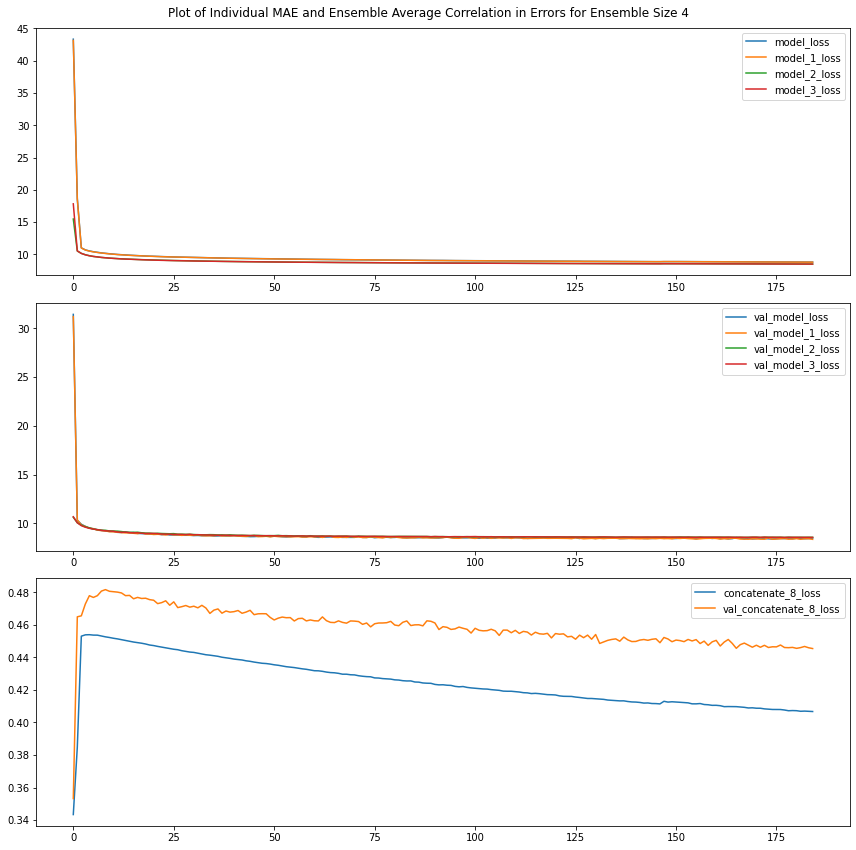

In [882]:
print(f'Epochs taken by 3 phases: {[len(h.history["loss"])for h in histories]}')
history_combined = pd.concat([pd.DataFrame(hist.history) for hist in histories]).reset_index(drop=True)

fig, ax = plt.subplots(3, figsize=(12,12))

plt.suptitle(f'Plot of Individual MAE and Ensemble Average Correlation in Errors for Ensemble Size {ENSEMBLE_SIZE}');
history_combined.filter(regex = '^model').plot(ax=ax[0], label='Training MAE Loss');
history_combined.filter(regex = '^val_model').plot(ax=ax[1], label='Training MAE Loss');
history_combined.filter(regex = 'concatenate').plot(ax=ax[-1], label='Avg Correlation');
plt.tight_layout();

In [883]:
history_combined.tail()

,loss,model_loss,model_1_loss,model_2_loss,model_3_loss,concatenate_8_loss,val_loss,val_model_loss,val_model_1_loss,val_model_2_loss,val_model_3_loss,val_concatenate_8_loss
180,36.303,8.827,8.814,8.523,8.511,0.407,35.882,8.482,8.452,8.585,8.581,0.446
181,36.284,8.817,8.807,8.523,8.509,0.407,35.789,8.462,8.380,8.583,8.579,0.446
182,36.276,8.815,8.805,8.519,8.509,0.407,35.818,8.439,8.437,8.579,8.576,0.447
183,36.267,8.811,8.801,8.518,8.509,0.407,35.855,8.452,8.443,8.587,8.589,0.446
184,36.259,8.811,8.804,8.515,8.502,0.407,35.804,8.498,8.374,8.579,8.572,0.445


In [ ]:
train_preds = ensemble_base.predict(x_train, batch_size=5000)
val_preds =  ensemble_base.predict(x_val, batch_size=5000)
test_preds = ensemble_base.predict(x_test, batch_size=5000)

### Correlations between predictions and errors in the negative corr model:

For predictions, a high correlation is expected. For errors, we see that the errors are generally lower than if we trained the models without a penalty for correlation in errors.

In [807]:
print(np.corrcoef(train_preds[-1], rowvar=False))
print()
print(np.corrcoef(val_preds[-1], rowvar=False))
print()
print(np.corrcoef(test_preds[-1], rowvar=False))

[[1.         0.99610252 0.99220817 0.99120242]
 [0.99610252 1.         0.99293286 0.9925207 ]
 [0.99220817 0.99293286 1.         0.99678303]
 [0.99120242 0.9925207  0.99678303 1.        ]]

[[1.         0.99572199 0.99342967 0.99260408]
 [0.99572199 1.         0.99443177 0.99402449]
 [0.99342967 0.99443177 1.         0.99687167]
 [0.99260408 0.99402449 0.99687167 1.        ]]

[[1.         0.99521211 0.98536713 0.98485419]
 [0.99521211 1.         0.98690252 0.98629038]
 [0.98536713 0.98690252 1.         0.99510123]
 [0.98485419 0.98629038 0.99510123 1.        ]]


In [987]:
print(np.corrcoef(train_preds[-1] - train_dataframe.drop(val_idx, axis=0).new_ys.values.reshape(-1,1), rowvar=False))
print()
print(np.corrcoef(val_preds[-1] - train_dataframe.iloc[val_idx].new_ys.values.reshape(-1,1), rowvar=False))
print()
print(np.corrcoef(test_preds[-1] - test_dataframe.new_ys.values.reshape(-1,1), rowvar=False))

[[1.         0.89963541 0.81795533 0.79483823]
 [0.89963541 1.         0.83213345 0.82336674]
 [0.81795533 0.83213345 1.         0.92840046]
 [0.79483823 0.82336674 0.92840046 1.        ]]

[[1.         0.90487138 0.86110896 0.84407077]
 [0.90487138 1.         0.88001568 0.87205063]
 [0.86110896 0.88001568 1.         0.93528738]
 [0.84407077 0.87205063 0.93528738 1.        ]]

[[1.         0.90502185 0.74825046 0.74491821]
 [0.90502185 1.         0.7779329  0.77224607]
 [0.74825046 0.7779329  1.         0.92485435]
 [0.74491821 0.77224607 0.92485435 1.        ]]


Most telling, perhaps, is the fact that we can see how diversity contributes to better model performance. The cell below shows the individual model MAEs and the combined prediction's MAE from the negative correlation model. 

Recall that the average normal model (baseline and bottleneck  architecture) has an MAE around 8.1; an ensemble of these models has MAE around 7.8-7.9. The individual models below all have poor MAE by that measure, but collectively have an MAE that is basically equivalent to the regular ensemble model. 

In [969]:
for pred in test_preds[:4]:
    print(mean_absolute_error(test_dataframe.new_ys, pred))
print(mean_absolute_error(test_dataframe.new_ys, test_preds[-1].mean(axis=1)))

8.18843079168664
8.158026486774927
8.239971035928034
8.19465824560889
7.8993647874461335


In [ ]:
ensemble_base.save('ensemble_multiple_loss_28-8')

In [970]:
neg_corr_preds = [f'neg_corr_{i}_pred' for i in range(ENSEMBLE_SIZE)]
neg_corr_errors = [f'neg_corr_{i}_error' for i in range(ENSEMBLE_SIZE)]

In [971]:
test_dataframe[neg_corr_preds] = test_preds[-1]
test_dataframe[neg_corr_errors] = test_preds[-1] - test_dataframe.new_ys.values.reshape(-1, 1)

In [973]:
test_dataframe[neg_corr_errors].corr()

,neg_corr_0_error,neg_corr_1_error,neg_corr_2_error,neg_corr_3_error
neg_corr_0_error,1.000,0.905,0.748,0.745
neg_corr_1_error,0.905,1.000,0.778,0.772
neg_corr_2_error,0.748,0.778,1.000,0.925
neg_corr_3_error,0.745,0.772,0.925,1.000


# Combining Negative Correlation Models and Regular Models

In [1036]:
# pd.set_option('display.max_colwidth', 200)

Load previously trained models for the regular ensemble and make predictions

In [ ]:
ensemble_models = []
ensemble_cols = [] 
prefix = 'baseline_ensemble_final_'
for i in range(0, 4):
    model_path = prefix+str(i)
    curr_model = keras.models.load_model(model_path)
    curr_pred = curr_model.predict(x_test, batch_size=5000)
    # curr_pred = curr_model.predict(x_test[:3] + [x_test[-1]] + x_test[3:-1], batch_size=5000)
    print(f'{f"{model_path}":30}: {mean_absolute_error(test_dataframe.new_ys, curr_pred):.3f}')
    ensemble_models.append(curr_model)
    test_dataframe[model_path+'_pred'] = curr_pred
    ensemble_cols.append(model_path+'_pred')
    
prefix = 'bottleneck_ensemble_final_'
for i in range(0, 4):
    model_path = prefix+str(i)
    curr_model = keras.models.load_model(model_path)
    curr_pred = curr_model.predict(x_test, batch_size=5000)
    print(f'{f"{model_path}":30}: {mean_absolute_error(test_dataframe.new_ys, curr_pred):.3f}')
    ensemble_models.append(curr_model)
    test_dataframe[model_path+'_pred'] = curr_pred
    ensemble_cols.append(model_path+'_pred')

In [785]:
def find_combinations(path, rem, k):
    if k == 0:
        combinations.append(path)
        return 
    else: 
        for i in range(len(rem)):
            find_combinations(path+[rem[i]], rem[i+1:], k-1)

In [786]:
ensemble_error_cols = []
for col in ensemble_cols:
    test_dataframe[col[:-4]+'error'] = test_dataframe.new_ys - test_dataframe[col]
    ensemble_error_cols.append(col[:-4]+'error')

a look at regular ensemble model error correlations (minimums)

In [1037]:
test_dataframe[ensemble_error_cols].corr().applymap(lambda x:  np.round(x,2)).min()

baseline_ensemble_final_0_error     0.910
baseline_ensemble_final_1_error     0.910
baseline_ensemble_final_2_error     0.900
baseline_ensemble_final_3_error     0.850
bottleneck_ensemble_final_0_error   0.870
bottleneck_ensemble_final_1_error   0.860
bottleneck_ensemble_final_2_error   0.880
bottleneck_ensemble_final_3_error   0.850
dtype: float64

In [795]:
prediction_cols = ensemble_cols  + neg_corr_preds

In [796]:
prediction_cols

['baseline_ensemble_final_0_pred',
 'baseline_ensemble_final_1_pred',
 'baseline_ensemble_final_2_pred',
 'baseline_ensemble_final_3_pred',
 'bottleneck_ensemble_final_0_pred',
 'bottleneck_ensemble_final_1_pred',
 'bottleneck_ensemble_final_2_pred',
 'bottleneck_ensemble_final_3_pred',
 'neg_corr_0_pred',
 'neg_corr_1_pred',
 'neg_corr_2_pred',
 'neg_corr_3_pred']

Looking at the optimal ensembles, the best models always have some portion of the negative correlation models in them.

===============================================TOP 5================================================


,ensemble_size,mae,combination
626,4.000,7.833,"[baseline_ensemble_final_2_pred, bottleneck_ensemble_final_0_pred, neg_corr_0_pred, neg_corr_1_pred]"
682,4.000,7.834,"[baseline_ensemble_final_3_pred, bottleneck_ensemble_final_0_pred, neg_corr_0_pred, neg_corr_1_pred]"
422,4.000,7.836,"[baseline_ensemble_final_0_pred, bottleneck_ensemble_final_0_pred, neg_corr_0_pred, neg_corr_1_pred]"
707,4.000,7.836,"[baseline_ensemble_final_3_pred, bottleneck_ensemble_final_2_pred, neg_corr_0_pred, neg_corr_1_pred]"
651,4.000,7.836,"[baseline_ensemble_final_2_pred, bottleneck_ensemble_final_2_pred, neg_corr_0_pred, neg_corr_1_pred]"



==============================================BOTTOM 5==============================================


,ensemble_size,mae,combination
3,1.000,8.168,[baseline_ensemble_final_3_pred]
8,1.000,8.188,[neg_corr_0_pred]
11,1.000,8.195,[neg_corr_3_pred]
1,1.000,8.211,[baseline_ensemble_final_1_pred]
10,1.000,8.240,[neg_corr_2_pred]


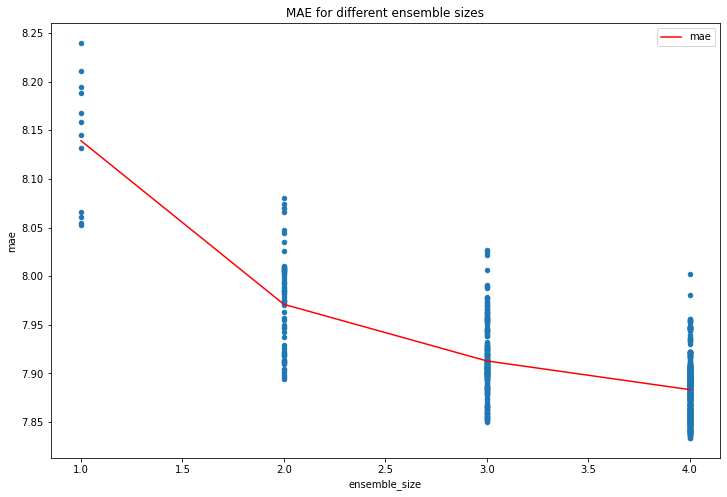

In [955]:
#we create ensemble predictions for every combination of sub-models of size k

ensemble_candidates = pd.DataFrame()
for k in range(1,5):
    combinations = []
    find_combinations([], prediction_cols, k)
    for combi in combinations: 
        mae = mean_absolute_error(test_dataframe[combi].mean(axis=1), test_dataframe.new_ys)
        ensemble_candidates = ensemble_candidates.append({'ensemble_size':k, 'mae':mae, 'combination': combi},
                                                      ignore_index=True)      
fig, ax = plt.subplots(figsize=(12,8))
ensemble_candidates.plot(x='ensemble_size', y='mae', ax=ax, kind='scatter');
ensemble_candidates.groupby('ensemble_size').mean().plot(ax=ax, label='mean', c='r');
ax.set_title('MAE for different ensemble sizes');

print(f'{"TOP 5":=^100}')
display(ensemble_candidates.sort_values('mae').head(5))  
print()

print(f'{"BOTTOM 5":=^100}')
display(ensemble_candidates.sort_values('mae').tail(5))  

In [974]:
temp = ensemble_candidates[ensemble_candidates.ensemble_size==4].sort_values(by='mae', ascending=True)
temp['bottleneck_count'] = temp.combination.apply(lambda y: sum([1 if 'bottleneck' in x else 0 for x in y]))
temp['baseline_count'] = temp.combination.apply(lambda y: sum([1 if 'baseline' in x else 0 for x in y]))
temp['neg_count'] = temp.combination.apply(lambda y: sum([1 if 'neg' in x else 0 for x in y]))

In [981]:
temp.groupby(['baseline_count', 'bottleneck_count', 'neg_count'])['mae'].min().sort_values()

baseline_count  bottleneck_count  neg_count
1               1                 2           7.833
0               2                 2           7.838
1               2                 1           7.838
0               1                 3           7.849
2               1                 1           7.850
1               0                 3           7.868
2               2                 0           7.872
                0                 2           7.880
0               3                 1           7.884
1               3                 0           7.899
0               0                 4           7.899
3               1                 0           7.904
                0                 1           7.920
0               4                 0           7.981
4               0                 0           8.002
Name: mae, dtype: float64

In [977]:
# temp.groupby(['baseline_count', 'bottleneck_count', 'neg_count']).mae.mean().sort_values()

In [962]:
def compare_mae_ranges(df, prediction_cols, error_cols):
    mae_range = []
    mad_range = []
    for col in error_cols:
        mae = abs(df[col]).mean()
        mad = abs(df[col]).median()
        mae_range.append(mae)
        mad_range.append(mad)
        print(f'{col:50}: MAE: {mae:.2f};    MAD: {mad:.2f}')
    
    mae = mean_absolute_error(df[prediction_cols].mean(axis=1), df.new_ys)
    mad = abs(df[prediction_cols].mean(axis=1) - df.new_ys).median() 
    print(f'{"COMBINED AVG PREDICTION":50}: MAE: {mae:.2f};    MAD: {mad:.2f}\n')
    print(f'{"MAE RANGE (INDIVIDUAL MODELS):":50}: {max(mae_range) - min(mae_range):.2f}')
    print(f'{"MAD RANGE (INDIVIDUAL MODELS):":50}: {max(mad_range) - min(mad_range):.2f}\n')
    print(f'{"MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):":50}: {min(mae_range) - mae:.2f}')
    print(f'{"MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):":50}: {min(mad_range) - mad:.2f}\n')
    
    print(f'{"MAE IMPROVEMENT (ENSEMBLE vs AVG):":50}: {sum(mae_range)/len(mae_range) - mae:.2f}')
    print(f'{"MAD IMPROVEMENT (ENSEMBLE vs AVG):":50}: {sum(mad_range)/len(mad_range) - mad:.2f}\n')
    
    print(f'{"NUMBER OF TRADES:":50}: {len(df):d}')
    print(f'{"NaN rows:":50}: {df[prediction_cols].isna().any(axis=1).sum():d}')

### Performance in different subsets based on last_yield for Regular Ensemble, Negative Correlation Ensemble and Mixed Ensemble (K=4):

Summarizing the findings below: 
- Overall MAE/MAD performance is mixed ensemble (7.81/4.59), regular ensemble (7.85/4.61), negative correlation ensemble (7.87/4.62)

- Outlier trades MAE/MAD performance is mixed ensemble (14.39/8.03), regular ensemble (14.62/8.34), negative correlation ensemble (14.67/8.22).Notably, the negative correlation ensemble has a better MAD than the regular ensemble by .1bps
    
- Regular trades MAE/MAD performance is mixed ensemble (7.67 / 4.55) , regular ensemble (7.72/4.56), negative correlation ensemble (7.73/ 4.57)

*Outlier trades are those beyond the 1th and 99th percentiles of last_yield*

In [993]:
col = 'last_yield'

test_dataframe_filtered = test_dataframe[(test_dataframe[col] > 0) & (test_dataframe[col] < 1000)]
lower = test_dataframe[col].quantile(.01)
upper = test_dataframe[col].quantile(.99)
upper_lower_filter = (test_dataframe_filtered[col]<lower) | (test_dataframe_filtered[col]>upper) 
print(f'Dropping trades with negative yields or yields over 10% for consistency with production (N={len(test_dataframe) - len(test_dataframe_filtered)}) \n')

print(f'{f"ALL TRADES (N = {len(test_dataframe_filtered)})":=^75}')

compare_mae_ranges(test_dataframe_filtered, neg_corr_preds, neg_corr_errors)

print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe_filtered)-upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[~upper_lower_filter], neg_corr_preds, neg_corr_errors)

print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[upper_lower_filter], neg_corr_preds, neg_corr_errors)

Dropping trades with negative yields or yields over 10% for consistency with production (N=67) 

==========================ALL TRADES (N = 720496)==========================
neg_corr_0_error                                  : MAE: 8.17;    MAD: 4.85
neg_corr_1_error                                  : MAE: 8.13;    MAD: 4.76
neg_corr_2_error                                  : MAE: 8.18;    MAD: 4.78
neg_corr_3_error                                  : MAE: 8.14;    MAD: 4.72
COMBINED AVG PREDICTION                           : MAE: 7.87;    MAD: 4.62

MAE RANGE (INDIVIDUAL MODELS):                    : 0.05
MAD RANGE (INDIVIDUAL MODELS):                    : 0.12

MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.26
MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.11

MAE IMPROVEMENT (ENSEMBLE vs AVG):                : 0.29
MAD IMPROVEMENT (ENSEMBLE vs AVG):                : 0.16

NUMBER OF TRADES:                                 : 720496
NaN rows:                                 

In [994]:
analysis_cols = ['baseline_ensemble_final_0_pred', 'baseline_ensemble_final_2_pred', 'bottleneck_ensemble_final_0_pred', 'bottleneck_ensemble_final_2_pred']
analysis_error_cols = [x[:-4] + 'error' for x in analysis_cols]

print(f'{f"ALL TRADES (N = {len(test_dataframe_filtered)})":=^75}')

compare_mae_ranges(test_dataframe_filtered, analysis_cols, analysis_error_cols)

print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe_filtered)-upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[~upper_lower_filter], analysis_cols, analysis_error_cols)

print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[upper_lower_filter], analysis_cols, analysis_error_cols)

==========================ALL TRADES (N = 720496)==========================
baseline_ensemble_final_0_error                   : MAE: 8.12;    MAD: 4.87
baseline_ensemble_final_2_error                   : MAE: 8.10;    MAD: 4.83
bottleneck_ensemble_final_0_error                 : MAE: 8.04;    MAD: 4.66
bottleneck_ensemble_final_2_error                 : MAE: 8.03;    MAD: 4.66
COMBINED AVG PREDICTION                           : MAE: 7.85;    MAD: 4.61

MAE RANGE (INDIVIDUAL MODELS):                    : 0.09
MAD RANGE (INDIVIDUAL MODELS):                    : 0.21

MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.18
MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.05

MAE IMPROVEMENT (ENSEMBLE vs AVG):                : 0.22
MAD IMPROVEMENT (ENSEMBLE vs AVG):                : 0.15

NUMBER OF TRADES:                                 : 720496
NaN rows:                                         : 0
===============2.30% < last_yield < 5.62% TRADES (N=706375)================
baseline_

In [995]:
analysis_cols = temp.combination.iloc[0]
analysis_error_cols = [x[:-4] + 'error' for x in analysis_cols]

print(f'{f"ALL TRADES (N = {len(test_dataframe_filtered)})":=^75}')

compare_mae_ranges(test_dataframe_filtered, analysis_cols, analysis_error_cols)

print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe_filtered)-upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[~upper_lower_filter], analysis_cols, analysis_error_cols)

print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')

compare_mae_ranges(test_dataframe_filtered[upper_lower_filter], analysis_cols, analysis_error_cols)

==========================ALL TRADES (N = 720496)==========================
baseline_ensemble_final_2_error                   : MAE: 8.10;    MAD: 4.83
bottleneck_ensemble_final_0_error                 : MAE: 8.04;    MAD: 4.66
neg_corr_0_error                                  : MAE: 8.17;    MAD: 4.85
neg_corr_1_error                                  : MAE: 8.13;    MAD: 4.76
COMBINED AVG PREDICTION                           : MAE: 7.81;    MAD: 4.59

MAE RANGE (INDIVIDUAL MODELS):                    : 0.13
MAD RANGE (INDIVIDUAL MODELS):                    : 0.19

MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.22
MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.07

MAE IMPROVEMENT (ENSEMBLE vs AVG):                : 0.30
MAD IMPROVEMENT (ENSEMBLE vs AVG):                : 0.18

NUMBER OF TRADES:                                 : 720496
NaN rows:                                         : 0
===============2.30% < last_yield < 5.62% TRADES (N=706375)================
baseline_